# CNN

Submission accuracy: `0.86884`

Download necessary NLTK files:
* `stopwords`: Stopwords Corpus
* `wordnet`: WordNet

In [1]:
%%script false
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.slim as slim
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from os.path import join
from tqdm import tqdm, trange

Using TensorFlow backend.


## Data loading

In [3]:
src = 'data'
df_train = pd.read_csv(join(src, 'labeledTrainData.tsv'), sep='\t')
df_train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
df_test = pd.read_csv(join(src, 'testData.tsv'), sep='\t')
df_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


## Data cleaning
During data cleaning, we perform the typical text normalization as in previous methods:

1. Remove HTML markup tags
1. Remove punctuation and whitespace
1. Convert to lowercase
1. Remove stopwords
1. Lemmatize words (WordNet)

In [5]:
lemmatizer = WordNetLemmatizer()
_stopwords = set(stopwords.words('english'))

def clean_sentence(sentence):
    removed_markup = BeautifulSoup(sentence, 'html.parser').get_text()
    removed_punctuation = re.sub(r'[^a-zA-Z]', ' ', removed_markup)
    tokens = removed_punctuation.lower().split()
    removed_stopwords = [w for w in tokens if w not in _stopwords]
    lemmatized = [lemmatizer.lemmatize(w) for w in removed_stopwords]
    return lemmatized

In [6]:
df_train['review_cleaned'] = [clean_sentence(s) for s in tqdm(df_train['review'])]
df_test['review_cleaned'] = [clean_sentence(s) for s in tqdm(df_test['review'])]

100%|██████████| 25000/25000 [00:17<00:00, 1424.71it/s]


In [7]:
review_train = list(df_train['review_cleaned'])
review_test = list(df_test['review_cleaned'])
len(review_train), len(review_test)

(25000, 25000)

### Tokenizer
The tokenizer converts words into a sequence of numbers.
```
[445, 86, 489, 10939, 8, 61, 583, ...]
```

Here we use Keras to tokenize our words.

In [8]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_train + review_test)

CPU times: user 2.82 s, sys: 19.9 ms, total: 2.83 s
Wall time: 2.83 s


In [9]:
tokenizer.word_index

{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'time': 5,
 'good': 6,
 'character': 7,
 'story': 8,
 'even': 9,
 'get': 10,
 'would': 11,
 'make': 12,
 'see': 13,
 'really': 14,
 'well': 15,
 'scene': 16,
 'much': 17,
 'bad': 18,
 'people': 19,
 'great': 20,
 'also': 21,
 'first': 22,
 'show': 23,
 'way': 24,
 'thing': 25,
 'made': 26,
 'life': 27,
 'could': 28,
 'think': 29,
 'go': 30,
 'know': 31,
 'watch': 32,
 'love': 33,
 'plot': 34,
 'actor': 35,
 'two': 36,
 'many': 37,
 'seen': 38,
 'year': 39,
 'say': 40,
 'end': 41,
 'never': 42,
 'acting': 43,
 'look': 44,
 'best': 45,
 'little': 46,
 'ever': 47,
 'man': 48,
 'better': 49,
 'take': 50,
 'come': 51,
 'work': 52,
 'still': 53,
 'part': 54,
 'something': 55,
 'director': 56,
 'find': 57,
 'want': 58,
 'back': 59,
 'give': 60,
 'lot': 61,
 'real': 62,
 'guy': 63,
 'watching': 64,
 'performance': 65,
 'woman': 66,
 'play': 67,
 'old': 68,
 'funny': 69,
 'though': 70,
 'another': 71,
 'actually': 72,
 'u': 73,
 'role': 74,
 'not

In [10]:
%%time
train_seq = tokenizer.texts_to_sequences(review_train)
test_seq = tokenizer.texts_to_sequences(review_test)

CPU times: user 1.59 s, sys: 8 ms, total: 1.59 s
Wall time: 1.59 s


### Padding
Pad sequences to the same length. Sentences exceeding the maximum length will be truncated. This is done via Keras as well.

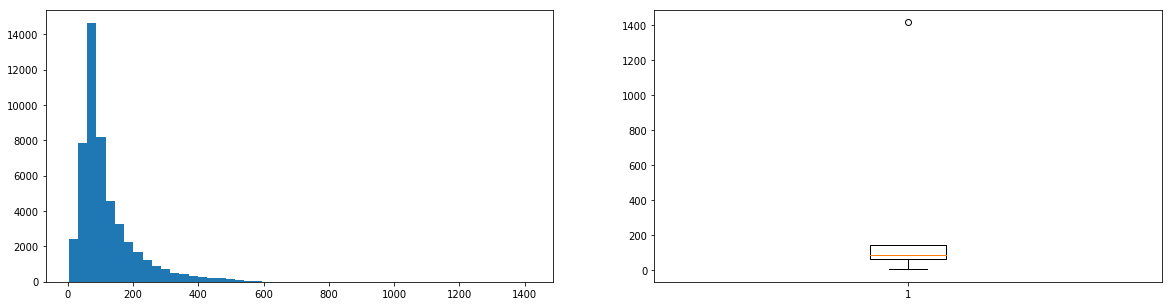

In [11]:
review_lengths = np.array([len(l) for l in review_test + review_train])

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(review_lengths, bins=50)
plt.subplot(1, 2, 2)
plt.boxplot(np.percentile(review_lengths, [0, 25, 50, 75, 100]))
plt.show();

Max. length of `200` is chosen here based on the boxplot.

In [12]:
%%time
maxlen = 200
train_seq_pad = pad_sequences(train_seq, maxlen=maxlen)
test_seq_pad = pad_sequences(test_seq, maxlen=maxlen)
print(train_seq_pad.shape, test_seq_pad.shape)

(25000, 200) (25000, 200)
CPU times: user 501 ms, sys: 88.1 ms, total: 589 ms
Wall time: 492 ms


## Model
Model implementation is obtained from the following paper:  
[Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)

In [13]:
class CNN(object):
    def __init__(self, vocab_size, embed_size=300):
        self.x = tf.placeholder(tf.int32, [None, None], name='inputs')  # [batch_size, seq_len]
        self.y = tf.placeholder(tf.int32, [None], name='labels')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        embed = self.embeddings(self.x, vocab_size, embed_size)
        logits = self.network(embed, embed_size)
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y, logits=logits)
        self.loss = tf.reduce_mean(losses)
        
        probs = tf.nn.softmax(logits)
        preds = tf.argmax(probs, axis=-1)
        correct_prediction = tf.equal(self.y, tf.cast(preds, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.inference = preds
        
        with tf.name_scope('inputs'):
            tf.summary.histogram('inputs', self.x)
            tf.summary.histogram('labels', self.y)
        with tf.name_scope('outputs'):
            tf.summary.histogram('embed', embed)
            tf.summary.histogram('logits', logits)
        with tf.name_scope('metrics'):
            tf.summary.scalar('loss', self.loss)
            tf.summary.scalar('accuracy', self.accuracy)
        self.summary = tf.summary.merge_all()
        
    def embeddings(self, inputs, vocab_size, embed_size):
        with tf.name_scope('embeddings'):
            embedding = tf.Variable(tf.random_uniform([vocab_size, embed_size], minval=-1, maxval=1))
            embed = tf.nn.embedding_lookup(embedding, self.x)  # [batch_size, seq_len, embed_size]
            embed = tf.expand_dims(embed, axis=-1)  # conv2d requires rank 4: NHWC
        return embed
    
    def network(self, inputs, embed_size, n_filters=100, filter_sizes=[3, 4, 5]):
        with tf.name_scope('conv'):
            outputs = []
            for filter_size in filter_sizes:
                conv = slim.conv2d(inputs, 100, [filter_size, embed_size], padding='VALID', scope=f'conv_{filter_size}')
                pool = slim.max_pool2d(conv, [200-filter_size+1, 1], padding='VALID', stride=1)
                outputs.append(pool)

        n_total_filters = n_filters * len(filter_sizes)
        output = tf.concat(outputs, axis=-1)
        output_flat = tf.reshape(output, [-1, n_total_filters])
        
        with tf.name_scope('fc'):
            net = slim.dropout(output_flat, keep_prob=self.keep_prob, scope='dropout1')
            net = slim.fully_connected(net, 2, activation_fn=None, scope='fc1')
        return net

In [14]:
# training hyperparameters
learning_rate = 1e-3
batch_size = 64
n_epochs = 4

model_path = 'model/cnn/model'
logdir = f'logs/cnn/lr{learning_rate}_batch{batch_size}'

In [15]:
tf.reset_default_graph()
model = CNN(len(tokenizer.word_index))

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(model.loss)

saver = tf.train.Saver()

In [16]:
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter(join(logdir, 'train'), sess.graph)
    val_writer = tf.summary.FileWriter(join(logdir, 'val'), sess.graph)
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        n_iters = int(np.ceil(len(train_seq_pad) / batch_size))
        for i in trange(n_iters - 1, desc=f'Epoch {epoch}'):
            x = train_seq_pad[i::n_iters]
            y = df_train['sentiment'][i::n_iters].values
            _, summary = sess.run([train_step, model.summary], feed_dict={
                model.x: x,
                model.y: y,
                model.keep_prob: 0.5,
            })
            train_writer.add_summary(summary, epoch*n_iters + i)
            
            if i % 10 == 0:
                summary = sess.run(model.summary, feed_dict={
                    model.x: train_seq_pad[n_iters-1::n_iters],
                    model.y: df_train['sentiment'][n_iters-1::n_iters].values,
                    model.keep_prob: 1.0,
                })
                val_writer.add_summary(summary, epoch*n_iters + i)
            
        saver.save(sess, model_path)

Epoch 3: 100%|██████████| 390/390 [01:03<00:00,  6.18it/s]


In [17]:
pred = []
with tf.Session() as sess:
    saver.restore(sess, model_path)
    for i in trange(0, len(test_seq_pad), batch_size):
        pred.extend(sess.run(model.inference, feed_dict={
            model.x: test_seq_pad[i:i+batch_size],
            model.keep_prob: 1.0,
        }))
len(pred)

INFO:tensorflow:Restoring parameters from model/cnn/model


100%|██████████| 391/391 [00:06<00:00, 64.20it/s]


25000

In [18]:
output = pd.DataFrame({'id': df_test['id'], 'sentiment': pred})
output

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1
5,2913_8,1
6,4396_1,0
7,395_2,1
8,10616_1,0
9,9074_9,1


In [19]:
output.to_csv('submission/word2vec_cnn.csv', index=False)